<a href="https://colab.research.google.com/github/xixilili/MSDS_458_Public/blob/master/MSDS458_Assignment_03/MSDS458_Assignment_03_Experiment_B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Experiments B: RNN: 
Try several experiments by tweaking (i) architecture (ii) Bidirectional/unidirectional & other hyper parameters, including regularization.

### Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Load Package

In [1]:
import datetime
from packaging import version
from collections import Counter
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

### Load and Process Data

In [2]:
# register  ag_news_subset so that tfds.load doesn't generate a checksum (mismatch) error
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=ag_news_subset

# Example Approaches to Split Data Set
# dataset, info = tfds.load('ag_news_subset', with_info=True,  split=['train[:]','test[:1000]', 'test[1000:]'],
dataset, info = tfds.load('ag_news_subset', with_info=True,  split=['train[:95%]','train[95%:]', 'test[:]'],
# dataset, info = tfds.load('ag_news_subset', with_info=True,  split=['train[:114000]','train[114000:]', 'test[:]'],
                          as_supervised=True)
train_dataset, validation_dataset, test_dataset = dataset
# train_dataset, test_dataset = dataset['train'],dataset['test']

2022-02-19 05:16:02.647009: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
I0219 05:16:02.647414 140330460178304 download_and_prepare.py:200] Running download_and_prepare for dataset(s):
ag_news_subset
I0219 05:16:02.940685 140330460178304 dataset_info.py:434] Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: ag_news_subset/1.0.0
I0219 05:16:03.430498 140330460178304 dataset_info.py:361] Load dataset info from /tmp/tmpz73_dz0ztfds
I0219 05:16:03.434282 140330460178304 download_and_prepare.py:138] download_and_prepare for dataset ag_news_subset/1.0.0...
I0219 05:16:03.434883 140330460178304 dataset_builder.py:357] Generating dataset ag_news_subset (/root/tensorflow_datasets/ag_news_subset/1.0.0)
Dl Completed...: 0 url [00:00, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]I0219 05:16:03.882712 140330460178304 download_manager.py:476] 

In [3]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

### Explore Vocab

In [4]:
def explore_vocab(train_dataset,encoder):
  doc_sizes = []
  corpus = []
  for example, _ in train_dataset.as_numpy_iterator():
    enc_example = encoder(example)
    doc_sizes.append(len(enc_example))
    corpus+=list(enc_example.numpy())
  return  corpus, doc_sizes

### Compile, Train Model

In [5]:
def namestr(obj, namespace):
  for name in namespace:
    if namespace[name] is obj:
      return name

In [6]:
import datetime as dt

def compile_train_model(model, epoch):
  #compile model
  model.compile(optimizer=tf.keras.optimizers.Adam(1e-4)
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we don not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

  start_datetime = dt.datetime.now()

  #train model  
  history = model.fit(train_dataset
                    ,epochs = epoch
                    ,validation_data=validation_dataset
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )


  #evaluate model
  loss, accuracy = model.evaluate(test_dataset)
  print('test set accuracy: ', accuracy * 100)

  runtime = (dt.datetime.now() - start_datetime).total_seconds()

  #training and validation performance metrix
  history_dict = history.history
  history_df=pd.DataFrame(history_dict)

  #loss and accuracy for training and validation data
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  result = history_df.tail(1)
  result['test_loss'] = loss
  result['test_accuracy'] = accuracy
  result['process_time'] = runtime
  result['epochs_setting'] = epoch  
  result['epochs_actual'] = epochs    

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
      plt.subplot(1, 2, i + 1)
      plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
      plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
      plt.legend()
      plt.title('{0} with {1} epochs'.format(namestr(model, globals()), epoch))   
  plt.show()  

  return result

## Simple RNN

### Encoder

In [7]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))
vocab = np.array(encoder.get_vocabulary());

In [8]:
corpus, doc_sizes = explore_vocab(train_dataset,encoder)

In [9]:
vocab = np.array(encoder.get_vocabulary())
num_vocab_words_in_corpus =len(vocab)

num_words =len(corpus)
num_articles =len(doc_sizes)
min_token_in_a_article = min(doc_sizes)
max_token_in_a_article = max(doc_sizes)  

print(num_vocab_words_in_corpus)
print(num_words)
print(num_articles)
print(min_token_in_a_article)
print(max_token_in_a_article)

1000
114000
1782
16
64


### Create Model

In [11]:
simpleRNN = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()),output_dim=64,mask_zero=True)
                              ,tf.keras.layers.SimpleRNN(units = 64)
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dense(4,activation='softmax')   # num_classes = 4
])


In [12]:
Multiplelayer_simpleRNN = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()),output_dim=64,mask_zero=True)
                              ,tf.keras.layers.SimpleRNN(units = 64, return_sequences=True)                              
                              ,tf.keras.layers.SimpleRNN(units = 64)
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dense(4,activation='softmax')   # num_classes = 4
])

In [13]:
BidirectionalRNN = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()),output_dim=64,mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(64)) 
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dense(4,activation='softmax')   # num_classes = 4
])

In [14]:
Multiplelayer_BidirectionalRNN = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()),output_dim=64,mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(64,  return_sequences=True))
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(32))
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dense(4,activation='softmax')   # num_classes = 4
])

In [16]:
Multiplelayer_BidirectionalRNN_Dropout = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()),output_dim=64,mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(64, return_sequences=True, recurrent_dropout=0.25))
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(32))
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dropout(0.5)                              
                              ,tf.keras.layers.Dense(4,activation='softmax')   # num_classes = 4
])

Recurrent dropout—This is a variant of dropout, used to fight overfitting in recurrent layers.
Stacking recurrent layers—This increases the representational power of the model (at the cost of higher computational loads).
Bidirectional recurrent layers—These present the same information to a recurrent network in different ways, increasing accuracy and mitigating forgetting issues.

### Simple RNN

Epoch 1/200
1782/1782 [==============================] - 72s 39ms/step - loss: 0.4941 - accuracy: 0.8228 - val_loss: 0.4662 - val_accuracy: 0.8360
Epoch 2/200
1782/1782 [==============================] - 71s 39ms/step - loss: 0.4662 - accuracy: 0.8324 - val_loss: 0.4611 - val_accuracy: 0.8350
Epoch 3/200
1782/1782 [==============================] - 71s 39ms/step - loss: 0.4546 - accuracy: 0.8370 - val_loss: 0.4523 - val_accuracy: 0.8408
Epoch 4/200
1782/1782 [==============================] - 69s 39ms/step - loss: 0.4341 - accuracy: 0.8464 - val_loss: 0.4260 - val_accuracy: 0.8483
Epoch 5/200
1782/1782 [==============================] - 70s 39ms/step - loss: 0.4133 - accuracy: 0.8532 - val_loss: 0.4156 - val_accuracy: 0.8523
Epoch 6/200
1782/1782 [==============================] - 70s 39ms/step - loss: 0.4000 - accuracy: 0.8579 - val_loss: 0.4113 - val_accuracy: 0.8552
Epoch 7/200
1782/1782 [==============================] - 70s 39ms/step - loss: 0.3904 - accuracy: 0.8606 - val_loss: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

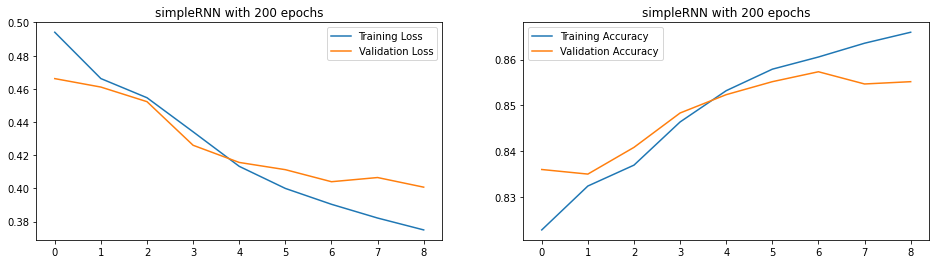

In [37]:
result_simpleRNN = compile_train_model(simpleRNN, 200)

In [38]:
result_simpleRNN['vocab_size'] = VOCAB_SIZE 
result_simpleRNN['num_words'] = num_words 
result_simpleRNN['num_articles'] = num_articles
result_simpleRNN['min_token_in_a_article'] = min_token_in_a_article 
result_simpleRNN['max_token_in_a_article'] = max_token_in_a_article 
new_col = ['SimpleRNN']   
result_simpleRNN.insert(loc=0, column='Model', value=new_col)

In [39]:
prev_results_df = pd.read_pickle('/content/gdrive/My Drive/Colab Notebooks/resultsA.pkl')
assignment_result_table = prev_results_df.append(result_simpleRNN,ignore_index=True)
assignment_result_table

,Model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,process_time,epochs_setting,epochs_actual,vocab_size,num_words,num_articles,min_token_in_a_article,max_token_in_a_article
0,RNN with 1000 vocab size,0.377154,0.863553,0.388227,0.862333,0.400026,0.853684,2233.756780,200,8,1000,114000,1782,16,64
1,RNN with 2000 vocab size,0.291024,0.896395,0.350998,0.874000,0.355715,0.872105,3211.853945,200,12,2000,114000,1782,16,64
2,RNN with 3000 vocab size,0.267700,0.904658,0.322919,0.886833,0.329175,0.884342,1899.668785,200,7,3000,114000,1782,16,64
3,RNN with filtered vocab that deleting the most...,0.377646,0.860895,0.392394,0.856833,0.403119,0.847763,2881.808089,200,11,898,114000,1782,16,64
4,RNN with 1000 vocab size 50 output sequence le...,0.367516,0.866158,0.391233,0.860333,0.399400,0.853026,2606.611799,200,13,1000,114000,1782,16,64
5,SimpleRNN,0.374977,0.865956,0.400744,0.855167,0.420890,0.850526,682.234513,200,9,1000,114000,1782,16,64


### Multiplelayer RNN

Epoch 1/200
1782/1782 [==============================] - 131s 72ms/step - loss: 0.4685 - accuracy: 0.8311 - val_loss: 0.4626 - val_accuracy: 0.8330
Epoch 2/200
1782/1782 [==============================] - 129s 72ms/step - loss: 0.4482 - accuracy: 0.8377 - val_loss: 0.4427 - val_accuracy: 0.8413
Epoch 3/200
1782/1782 [==============================] - 128s 72ms/step - loss: 0.4320 - accuracy: 0.8436 - val_loss: 0.4262 - val_accuracy: 0.8495
Epoch 4/200
1782/1782 [==============================] - 128s 72ms/step - loss: 0.4109 - accuracy: 0.8515 - val_loss: 0.4164 - val_accuracy: 0.8465
Epoch 5/200
1782/1782 [==============================] - 128s 72ms/step - loss: 0.3935 - accuracy: 0.8580 - val_loss: 0.4039 - val_accuracy: 0.8542
Epoch 6/200
1782/1782 [==============================] - 129s 72ms/step - loss: 0.3815 - accuracy: 0.8621 - val_loss: 0.3956 - val_accuracy: 0.8573
Epoch 7/200
1782/1782 [==============================] - 129s 72ms/step - loss: 0.3715 - accuracy: 0.8655 - val_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

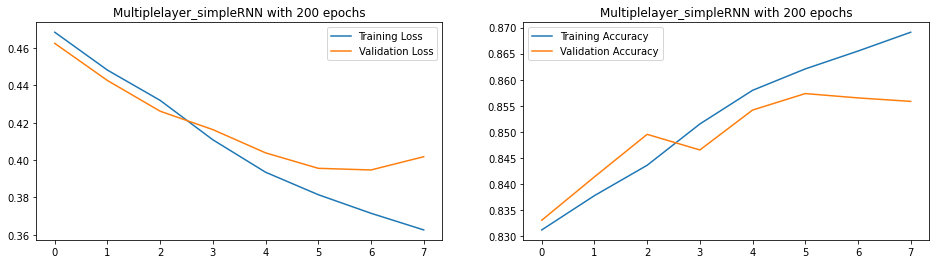

In [40]:
result_msimpleRNN = compile_train_model(Multiplelayer_simpleRNN, 200)

In [41]:
result_msimpleRNN['vocab_size'] = VOCAB_SIZE 
result_msimpleRNN['num_words'] = num_words 
result_msimpleRNN['num_articles'] = num_articles
result_msimpleRNN['min_token_in_a_article'] = min_token_in_a_article 
result_msimpleRNN['max_token_in_a_article'] = max_token_in_a_article 
new_col = ['Multiplelayer RNN']   
result_msimpleRNN.insert(loc=0, column='Model', value=new_col)

In [42]:
assignment_result_table = assignment_result_table.append(result_msimpleRNN,ignore_index=True)
assignment_result_table

,Model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,process_time,epochs_setting,epochs_actual,vocab_size,num_words,num_articles,min_token_in_a_article,max_token_in_a_article
0,RNN with 1000 vocab size,0.377154,0.863553,0.388227,0.862333,0.400026,0.853684,2233.756780,200,8,1000,114000,1782,16,64
1,RNN with 2000 vocab size,0.291024,0.896395,0.350998,0.874000,0.355715,0.872105,3211.853945,200,12,2000,114000,1782,16,64
2,RNN with 3000 vocab size,0.267700,0.904658,0.322919,0.886833,0.329175,0.884342,1899.668785,200,7,3000,114000,1782,16,64
3,RNN with filtered vocab that deleting the most...,0.377646,0.860895,0.392394,0.856833,0.403119,0.847763,2881.808089,200,11,898,114000,1782,16,64
4,RNN with 1000 vocab size 50 output sequence le...,0.367516,0.866158,0.391233,0.860333,0.399400,0.853026,2606.611799,200,13,1000,114000,1782,16,64
5,SimpleRNN,0.374977,0.865956,0.400744,0.855167,0.420890,0.850526,682.234513,200,9,1000,114000,1782,16,64
6,Multiplelayer RNN,0.362619,0.869114,0.401836,0.855833,0.422530,0.849474,1086.008980,200,8,1000,114000,1782,16,64


### Bidirectional RNN

Epoch 1/200
1782/1782 [==============================] - 125s 68ms/step - loss: 0.4266 - accuracy: 0.8469 - val_loss: 0.4189 - val_accuracy: 0.8515
Epoch 2/200
1782/1782 [==============================] - 122s 68ms/step - loss: 0.4006 - accuracy: 0.8559 - val_loss: 0.3975 - val_accuracy: 0.8577
Epoch 3/200
1782/1782 [==============================] - 121s 68ms/step - loss: 0.3880 - accuracy: 0.8594 - val_loss: 0.4025 - val_accuracy: 0.8570
Epoch 4/200
1782/1782 [==============================] - 122s 68ms/step - loss: 0.3789 - accuracy: 0.8626 - val_loss: 0.3911 - val_accuracy: 0.8648
Epoch 5/200
1782/1782 [==============================] - 122s 68ms/step - loss: 0.3695 - accuracy: 0.8657 - val_loss: 0.3878 - val_accuracy: 0.8635
Epoch 6/200
119/119 [==============================] - 2s 20ms/step - loss: 0.4054 - accuracy: 0.8518
test set accuracy:  85.18421053886414


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

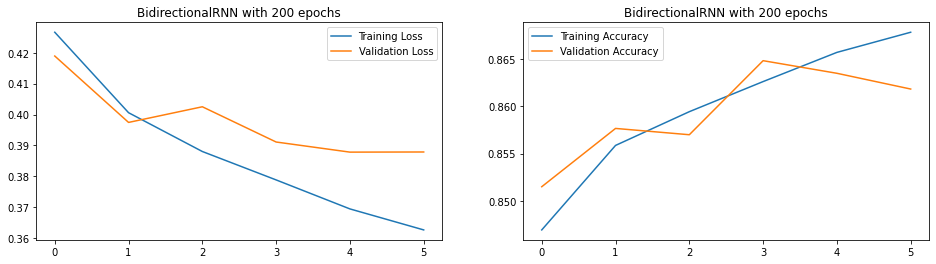

In [43]:
result_BiRNN = compile_train_model(BidirectionalRNN, 200)

In [44]:
result_BiRNN['vocab_size'] = VOCAB_SIZE 
result_BiRNN['num_words'] = num_words 
result_BiRNN['num_articles'] = num_articles
result_BiRNN['min_token_in_a_article'] = min_token_in_a_article 
result_BiRNN['max_token_in_a_article'] = max_token_in_a_article 
new_col = ['Bidirectional RNN']   
result_BiRNN.insert(loc=0, column='Model', value=new_col)

In [45]:
assignment_result_table = assignment_result_table.append(result_BiRNN,ignore_index=True)
assignment_result_table

,Model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,process_time,epochs_setting,epochs_actual,vocab_size,num_words,num_articles,min_token_in_a_article,max_token_in_a_article
0,RNN with 1000 vocab size,0.377154,0.863553,0.388227,0.862333,0.400026,0.853684,2233.756780,200,8,1000,114000,1782,16,64
1,RNN with 2000 vocab size,0.291024,0.896395,0.350998,0.874000,0.355715,0.872105,3211.853945,200,12,2000,114000,1782,16,64
2,RNN with 3000 vocab size,0.267700,0.904658,0.322919,0.886833,0.329175,0.884342,1899.668785,200,7,3000,114000,1782,16,64
3,RNN with filtered vocab that deleting the most...,0.377646,0.860895,0.392394,0.856833,0.403119,0.847763,2881.808089,200,11,898,114000,1782,16,64
4,RNN with 1000 vocab size 50 output sequence le...,0.367516,0.866158,0.391233,0.860333,0.399400,0.853026,2606.611799,200,13,1000,114000,1782,16,64
5,SimpleRNN,0.374977,0.865956,0.400744,0.855167,0.420890,0.850526,682.234513,200,9,1000,114000,1782,16,64
6,Multiplelayer RNN,0.362619,0.869114,0.401836,0.855833,0.422530,0.849474,1086.008980,200,8,1000,114000,1782,16,64
7,Bidirectional RNN,0.362689,0.867842,0.387893,0.861833,0.405440,0.851842,797.343860,200,6,1000,114000,1782,16,64


### Multiplelayer Bidirectional RNN

Epoch 1/200
1782/1782 [==============================] - 224s 123ms/step - loss: 0.4167 - accuracy: 0.8501 - val_loss: 0.4042 - val_accuracy: 0.8568
Epoch 2/200
1782/1782 [==============================] - 220s 123ms/step - loss: 0.3911 - accuracy: 0.8586 - val_loss: 0.4035 - val_accuracy: 0.8513
Epoch 3/200
119/119 [==============================] - 4s 35ms/step - loss: 0.4314 - accuracy: 0.8449
test set accuracy:  84.48684215545654


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

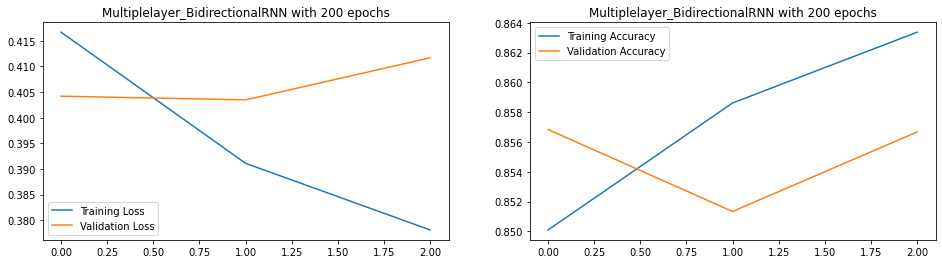

In [46]:
result_MBiRNN = compile_train_model(Multiplelayer_BidirectionalRNN, 200)

In [47]:
result_MBiRNN['vocab_size'] = VOCAB_SIZE 
result_MBiRNN['num_words'] = num_words 
result_MBiRNN['num_articles'] = num_articles
result_MBiRNN['min_token_in_a_article'] = min_token_in_a_article 
result_MBiRNN['max_token_in_a_article'] = max_token_in_a_article 
new_col = ['Multiplelayer Bidirectional RNN']   
result_MBiRNN.insert(loc=0, column='Model', value=new_col)

In [48]:
assignment_result_table = assignment_result_table.append(result_MBiRNN,ignore_index=True)
assignment_result_table

,Model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,process_time,epochs_setting,epochs_actual,vocab_size,num_words,num_articles,min_token_in_a_article,max_token_in_a_article
0,RNN with 1000 vocab size,0.377154,0.863553,0.388227,0.862333,0.400026,0.853684,2233.756780,200,8,1000,114000,1782,16,64
1,RNN with 2000 vocab size,0.291024,0.896395,0.350998,0.874000,0.355715,0.872105,3211.853945,200,12,2000,114000,1782,16,64
2,RNN with 3000 vocab size,0.267700,0.904658,0.322919,0.886833,0.329175,0.884342,1899.668785,200,7,3000,114000,1782,16,64
3,RNN with filtered vocab that deleting the most...,0.377646,0.860895,0.392394,0.856833,0.403119,0.847763,2881.808089,200,11,898,114000,1782,16,64
4,RNN with 1000 vocab size 50 output sequence le...,0.367516,0.866158,0.391233,0.860333,0.399400,0.853026,2606.611799,200,13,1000,114000,1782,16,64
5,SimpleRNN,0.374977,0.865956,0.400744,0.855167,0.420890,0.850526,682.234513,200,9,1000,114000,1782,16,64
6,Multiplelayer RNN,0.362619,0.869114,0.401836,0.855833,0.422530,0.849474,1086.008980,200,8,1000,114000,1782,16,64
7,Bidirectional RNN,0.362689,0.867842,0.387893,0.861833,0.405440,0.851842,797.343860,200,6,1000,114000,1782,16,64
8,Multiplelayer Bidirectional RNN,0.378119,0.863360,0.411663,0.856667,0.431394,0.844868,708.051660,200,3,1000,114000,1782,16,64


### Multiplelayer Bidirectional RNN Dropout

Epoch 1/200
1782/1782 [==============================] - 243s 134ms/step - loss: 1.2194 - accuracy: 0.4089 - val_loss: 0.9272 - val_accuracy: 0.5763
Epoch 2/200
1782/1782 [==============================] - 239s 134ms/step - loss: 0.9038 - accuracy: 0.6076 - val_loss: 0.7396 - val_accuracy: 0.6942
Epoch 3/200
1782/1782 [==============================] - 238s 133ms/step - loss: 0.6915 - accuracy: 0.7467 - val_loss: 0.4849 - val_accuracy: 0.8360
Epoch 4/200
1782/1782 [==============================] - 238s 133ms/step - loss: 0.5107 - accuracy: 0.8295 - val_loss: 0.4307 - val_accuracy: 0.8517
Epoch 5/200
1782/1782 [==============================] - 239s 134ms/step - loss: 0.4645 - accuracy: 0.8441 - val_loss: 0.4232 - val_accuracy: 0.8568
Epoch 6/200
1782/1782 [==============================] - 239s 134ms/step - loss: 0.4440 - accuracy: 0.8498 - val_loss: 0.4135 - val_accuracy: 0.8573
Epoch 7/200
1782/1782 [==============================] - 240s 135ms/step - loss: 0.4303 - accuracy: 0.8544

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

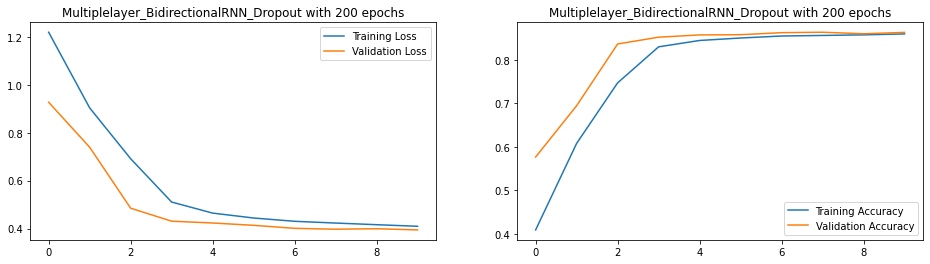

In [49]:
result_MBiDRNN = compile_train_model(Multiplelayer_BidirectionalRNN_Dropout, 200)

In [50]:
result_MBiDRNN['vocab_size'] = VOCAB_SIZE 
result_MBiDRNN['num_words'] = num_words 
result_MBiDRNN['num_articles'] = num_articles
result_MBiDRNN['min_token_in_a_article'] = min_token_in_a_article 
result_MBiDRNN['max_token_in_a_article'] = max_token_in_a_article 
new_col = ['Multiplelayer Bidirectional RNN with Dropout']   
result_MBiDRNN.insert(loc=0, column='Model', value=new_col)

In [51]:
assignment_result_table = assignment_result_table.append(result_MBiDRNN,ignore_index=True)
assignment_result_table

,Model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,process_time,epochs_setting,epochs_actual,vocab_size,num_words,num_articles,min_token_in_a_article,max_token_in_a_article
0,RNN with 1000 vocab size,0.377154,0.863553,0.388227,0.862333,0.400026,0.853684,2233.756780,200,8,1000,114000,1782,16,64
1,RNN with 2000 vocab size,0.291024,0.896395,0.350998,0.874000,0.355715,0.872105,3211.853945,200,12,2000,114000,1782,16,64
2,RNN with 3000 vocab size,0.267700,0.904658,0.322919,0.886833,0.329175,0.884342,1899.668785,200,7,3000,114000,1782,16,64
3,RNN with filtered vocab that deleting the most...,0.377646,0.860895,0.392394,0.856833,0.403119,0.847763,2881.808089,200,11,898,114000,1782,16,64
4,RNN with 1000 vocab size 50 output sequence le...,0.367516,0.866158,0.391233,0.860333,0.399400,0.853026,2606.611799,200,13,1000,114000,1782,16,64
5,SimpleRNN,0.374977,0.865956,0.400744,0.855167,0.420890,0.850526,682.234513,200,9,1000,114000,1782,16,64
6,Multiplelayer RNN,0.362619,0.869114,0.401836,0.855833,0.422530,0.849474,1086.008980,200,8,1000,114000,1782,16,64
7,Bidirectional RNN,0.362689,0.867842,0.387893,0.861833,0.405440,0.851842,797.343860,200,6,1000,114000,1782,16,64
8,Multiplelayer Bidirectional RNN,0.378119,0.863360,0.411663,0.856667,0.431394,0.844868,708.051660,200,3,1000,114000,1782,16,64
9,Multiplelayer Bidirectional RNN with Dropout,0.409446,0.859158,0.394270,0.862667,0.414101,0.850132,2583.185984,200,10,1000,114000,1782,16,64


## Save data

In [52]:
assignment_result_table.to_pickle("/content/gdrive/My Drive/Colab Notebooks/resultsB.pkl") 
assignment_result_table.to_csv("/content/gdrive/My Drive/Colab Notebooks/resultsB.csv") 